# Linear regression from scratch

Powerful ML libraries can eliminate repetitive work, but if you rely too much on abstractions, you might never learn how neural networks really work under the hood. So for this first example, let's get our hands dirty and build everything from scratch, relying only on autograd and NDArray. First, we'll import the same dependencies as in the [autograd chapter](../chapter01_crashcourse/autograd.ipynb). We'll also import the powerful `gluon` package  but in this chapter, we'll only be using it for data loading.

In [1]:
from __future__ import print_function
import mxnet as mx
from mxnet import nd, autograd, gluon
mx.random.seed(1)

## Set the context

We'll also want to specify the contexts where computation should happen. This tutorial is so simple that you could probably run it on a calculator watch. But, to develop good habits we're going to specify two contexts: one for data and one for our models. 

In [2]:
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()
data_ctx = ctx
model_ctx = ctx

## Linear regression


To get our feet wet, we'll start off by looking at the problem of regression.
This is the task of predicting a *real valued target* $y$ given a data point $x$.
In linear regression, the simplest and still perhaps the most useful approach,
we assume that prediction can be expressed as a *linear* combination of the input features 
(thus giving the name *linear* regression):

$$\hat{y} = w_1 \cdot x_1 + ... + w_d \cdot x_d + b$$


Given a collection of data points $X$, and corresponding target values $\boldsymbol{y}$, 
we'll try to find the *weight* vector $\boldsymbol{w}$ and bias term $b$ 
(also called an *offset* or *intercept*)
that approximately associate data points $\boldsymbol{x}_i$ with their corresponding labels ``y_i``. 
Using slightly more advanced math notation, we can express the predictions $\boldsymbol{\hat{y}}$
corresponding to a collection of datapoints $X$ via the matrix-vector product:

$$\boldsymbol{\hat{y}} = X \boldsymbol{w} + b$$


Before we can get going, we will need two more things 

* Some way to measure the quality of the current model  
* Some way to manipulate the model to improve its quality


### Square loss
In order to say whether we've done a good job, 
we need some way to measure the quality of a model. 
Generally, we will define a *loss function*
that says *how far* are our predictions from the correct answers.
For the classical case of linear regression, 
we usually focus on the squared error.
Specifically, our loss will be the sum, over all examples, of the squared error $(y_i-\hat{y})^2)$ on each:

$$\ell(y, \hat{y}) = \sum_{i=1}^n (\hat{y}_i-y_i)^2.$$


For one-dimensional data, we can easily visualize the relationship between our single feature and the target variable. It's also easy to visualize a linear predictor and it's error on each example. 
Note that squared loss *heavily penalizes outliers*. For the visualized predictor below, the lone outlier would contribute most of the loss.

![](../img/linear-regression.png)


### Manipulating the model

For us to minimize the error,
we need some mechanism to alter the model.
We do this by choosing values of the *parameters*
$\boldsymbol{w}$ and $b$.
This is the only job of the learning algorithm.
Take training data ($X$, $y$) and the functional form of the model $\hat{y} = X\boldsymbol{w} + b$.
Learning then consists of choosing the best possible $\boldsymbol{w}$ and $b$ based on the available evidence.





### Historical note

You might reasonably point out that linear regression is a classical statistical model.
[According to Wikipedia](https://en.wikipedia.org/wiki/Regression_analysis#History), 
Legendre first developed the method of least squares regression in 1805,
which was shortly thereafter rediscovered by Gauss in 1809. 
Presumably, Legendre, who had Tweeted about the paper several times,
was peeved that Gauss failed to cite his arXiv preprint. 

![Legendre](../img/legendre.jpeg)


Matters of provenance aside, you might wonder - if Legendre and Gauss 
worked on linear regression, does that mean there were the original deep learning researchers?
And if linear regression doesn't wholly belong to deep learning, 
then why are we presenting a linear model 
as the first example in a tutorial series on neural networks? 
Well it turns out that we can express linear regression 
as the simplest possible (useful) neural network. 
A neural network is just a collection of nodes (aka neurons) connected by directed edges. 
In most networks, we arrange the nodes into layers with each feeding its output into the layer above. 
To calculate the value of any node, we first perform a weighted sum of the inputs (according to weights ``w``) 
and then apply an *activation function*. 
For linear regression, we only have two layers, one corresponding to the input (depicted in orange) 
and a one-node layer (depicted in green) correspnding to the ouput.
For the output node the activation function is just the identity function.

![](../img/onelayer.png)

While you certainly don't have to view linear regression through the lens of deep learning, 
you can (and we will!).
To ground the concepts that we just discussed in code, 
let's actually code up a neural network for linear regression from scratch.


To get going, we will generate a simple synthetic dataset by sampling random data points ``X[i]`` and corresponding labels ``y[i]`` in the following manner. Out inputs will each be sampled from a random normal distribution with mean $0$ and variance $1$. Our features will be independent. Another way of saying this is that they will have diagonal covariance.  The labels will be generated accoding to the *true* labeling function `y[i] = 2 * X[i][0]- 3.4 * X[i][1] + 4.2 + noise` where the noise is drawn from a random gaussian with mean ``0`` and variance ``.01``. We could express the labeling function in mathematical notation as:
$$y = X \cdot w + b + \eta, \quad \text{for } \eta \sim \mathcal{N}(0,\sigma^2)$$ 


In [3]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2
    
X = nd.random_normal(shape=(num_examples, num_inputs), ctx=data_ctx)
noise = .1 * nd.random_normal(shape=(num_examples,), ctx=data_ctx)
y = real_fn(X) + noise

Notice that each row in ``X`` consists of a 2-dimensional data point and that each row in ``Y`` consists of a 1-dimensional target value. 

In [4]:
print(X[0])
print(y[0])


[0.16667041 0.56428516]
<NDArray 2 @gpu(0)>

[2.6159384]
<NDArray 1 @gpu(0)>


Note that because our synthetic features `X` live on `data_ctx` and because our noise also lives on `data_ctx`, the labels `y`, produced by combining `X` and `noise` in `real_fn` also live on `data_ctx`. 
We can confirm that for any randomly chosen point, 
a linear combination with the (known) optimal parameters 
produces a prediction that is indeed close to the target value

In [5]:
print(2 * X[0, 0] - 3.4 * X[0, 1] + 4.2)


[2.6147711]
<NDArray 1 @gpu(0)>


We can visualize the correspondence between our second feature (``X[:, 1]``) and the target values ``Y`` by generating a scatter plot with the Python plotting package ``matplotlib``. Make sure that ``matplotlib`` is installed. Otherwise, you may install it by running ``pip2 install matplotlib`` (for Python 2) or ``pip3 install matplotlib`` (for Python 3) on your command line. 

In order to plot with ``matplotlib`` we'll just need to convert ``X`` and ``y`` into NumPy arrays by using the `.asnumpy()` function. 

In [6]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1].asnumpy(),y.asnumpy())
plt.show()

<Figure size 640x480 with 1 Axes>

## Data iterators

Once we start working with neural networks, we're going to need to iterate through our data points quickly. We'll also want to be able to grab batches of ``k`` data points at a time, to shuffle our data. In MXNet, data iterators give us a nice set of utilities for fetching and manipulating data. In particular, we'll work with the simple  ``DataLoader`` class, that provides an intuitive way to use an ``ArrayDataset`` for training models.


We can load `X` and `y` into an ArrayDataset, by calling `gluon.data.ArrayDataset(X, y)`. It's ok for `X` to be a multi-dimensional input array (say, of images) and `y` to be just a one-dimensional array of labels. The one requirement is that they have equal lengths along the first axis, i.e., `len(X) == len(y)`. 

Given an `ArrayDataset`, we can create a DataLoader which will grab random batches of data from an `ArrayDataset`.  We'll want to specify two arguments. First, we'll need to say the `batch_size`, i.e., how many examples we want to grab at a time. Second, we'll want to specify whether or not to shuffle the data between iterations through the dataset. 

In [7]:
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y),
                                   batch_size=batch_size, shuffle=True)

Once we've initialized our DataLoader (``train_data``), we can easily fetch batches by iterating over `train_data` just as if it were a Python list. You can use your favorite iterating techniques like foreach loops: `for data, label in train_data` or enumerations: `for i, (data, label) in enumerate(train_data)`. 
First, let's just grab one batch and break out of the loop.

In [8]:
for i, (data, label) in enumerate(train_data):
    print(data, label)
    break


[[-1.602276    0.9898138 ]
 [ 1.481699   -0.14081518]
 [-0.26883852  0.7837113 ]
 [-1.6248507   0.31165943]]
<NDArray 4x2 @gpu(0)> 
[-2.263986    7.7829123   1.0900135  -0.22665015]
<NDArray 4 @cpu(0)>


If we run that same code again you'll notice that we get a different batch. That's because we instructed the `DataLoader` that `shuffle=True`. 

In [9]:
for i, (data, label) in enumerate(train_data):
    print(data, label)
    break


[[-0.02239015 -0.7887862 ]
 [ 1.6813437  -1.3405347 ]
 [ 2.003352   -0.02458715]
 [-1.0817286   1.1433666 ]]
<NDArray 4x2 @gpu(0)> 
[ 6.9223394 12.139149   8.139431  -1.9621334]
<NDArray 4 @cpu(0)>


Finally, if we actually pass over the entire dataset, and count the number of batches, we'll find that there are 2500 batches. We expect this because our dataset has 10,000 examples and we configured the `DataLoader` with a batch size of 4.

In [10]:
counter = 0
for i, (data, label) in enumerate(train_data):
    pass
print(i+1)

2500


## Model parameters

Now let's allocate some memory for our parameters and set their initial values. We'll want to initialize these parameters on the `model_ctx`. 

In [11]:
w = nd.random_normal(shape=(num_inputs, num_outputs), ctx=model_ctx)
b = nd.random_normal(shape=num_outputs, ctx=model_ctx)
params = [w, b]

In the succeeding cells, we're going to update these parameters to better fit our data. This will involve taking the gradient (a multi-dimensional derivative) of some *loss function* with respect to the parameters. We'll update each parameter in the direction that reduces the loss. But first, let's just allocate some memory for each gradient.

In [12]:
for param in params:
    param.attach_grad()

## Neural networks

Next we'll want to define our model. In this case, we'll be working with linear models, the simplest possible *useful* neural network. To calculate the output of the linear model, we simply multiply a given input with the model's weights (``w``), and add the offset ``b``.

In [13]:
def net(X):
    return mx.nd.dot(X, w) + b

Ok, that was easy.

## Loss function

Train a model means making it better and better over the course of a period of training. But in order for this goal to make any sense at all, we first need to define what *better* means in the first place. In this case, we'll use the squared distance between our prediction and the true value. 

In [14]:
def square_loss(yhat, y): 
    return nd.mean((yhat - y) ** 2)

## Optimizer

It turns out that linear regression actually has a closed-form solution. However, most interesting models that we'll care about cannot be solved analytically. So we'll solve this problem by stochastic gradient descent. At each step, we'll estimate the gradient of the loss with respect to our weights, using one batch randomly drawn from our dataset. Then, we'll update our parameters a small amount in the direction that reduces the loss. The size of the step is determined by the *learning rate* ``lr``. 

In [15]:
def SGD(params, lr):    
    for param in params:
        param[:] = param - lr * param.grad

## Execute training loop

Now that we have all the pieces, we just need to wire them together by writing a training loop. 
First we'll define ``epochs``, the number of passes to make over the dataset. Then for each pass, we'll iterate through ``train_data``, grabbing batches of examples and their corresponding labels. 

For each batch, we'll go through the following ritual:
     
* Generate predictions (``yhat``) and the loss (``loss``) by executing a forward pass through the network.
* Calculate gradients by making a backwards pass through the network (``loss.backward()``). 
* Update the model parameters by invoking our SGD optimizer.     


In [16]:
epochs = 10
learning_rate = .0001
num_batches = num_examples/batch_size

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx).reshape((-1, 1))
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += loss.asscalar()
    print(cumulative_loss / num_batches)

14.469190785199403
5.362887919908762
1.9919095009990035
0.7439252201084048
0.28179860604852436
0.11059072826532647
0.047190655502688604
0.023707161466428078
0.014985548794906935
0.011751106304011773


## Visualizing our training progess

In the succeeding chapters, we'll introduce more realistic data, fancier models, more complicated loss functions, and more. But the core ideas are the same and the training loop will look remarkably familiar. Because these tutorials are self-contained, you'll get to know this ritual quite well. In addition to updating out model, we'll often want to do some bookkeeping. Among other things, we might want to keep track of training progress and visualize it graphically. We demonstrate one slighly more sophisticated training loop below.

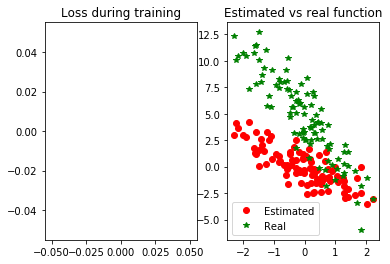

Epoch 0, batch 2499. Mean loss: 19.501890830361845
Epoch 1, batch 2499. Mean loss: 7.239508446532488
Epoch 2, batch 2499. Mean loss: 2.692345428779721
Epoch 3, batch 2499. Mean loss: 1.0053576689764858
Epoch 4, batch 2499. Mean loss: 0.37949909101203083
Epoch 5, batch 2499. Mean loss: 0.14719825291596353
Epoch 6, batch 2499. Mean loss: 0.060934675494488326
Epoch 7, batch 2499. Mean loss: 0.028840992161561736
Epoch 8, batch 2499. Mean loss: 0.01690735936817946
Epoch 9, batch 2499. Mean loss: 0.012483743364480325


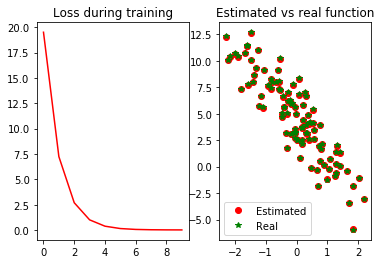

In [17]:
############################################
#    Re-initialize parameters because they 
#    were already trained in the first loop
############################################
w[:] = nd.random_normal(shape=(num_inputs, num_outputs), ctx=model_ctx)
b[:] = nd.random_normal(shape=num_outputs, ctx=model_ctx)

############################################
#    Script to plot the losses over time
############################################
def plot(losses, X, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             net(X[:sample_size, :]).asnumpy(), 'or', label='Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             real_fn(X[:sample_size, :]).asnumpy(), '*g', label='Real')
    fg2.legend()

    plt.show()

learning_rate = .0001
losses = []
plot(losses, X)

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx).reshape((-1, 1))
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        cumulative_loss += loss.asscalar()

    print("Epoch %s, batch %s. Mean loss: %s" % (e, i, cumulative_loss/num_batches))
    losses.append(cumulative_loss/num_batches)
            
plot(losses, X)

## Conclusion 

You've seen that using just mxnet.ndarray and mxnet.autograd, we can build statistical models from scratch. In the following tutorials, we'll build on this foundation, introducing the basic ideas behind modern neural networks and demonstrating the powerful abstractions in MXNet's `gluon` package for building complex models with little code. 

## Next
[Linear regression with gluon](../chapter02_supervised-learning/linear-regression-gluon.ipynb)

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)